In [1]:
%matplotlib inline

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from e11 import H5Scan, H5Data

# Raw datasets
---

This notebook demonstrates how to use `e11.H5Scan()` and `e11.H5Data()` to access experimental datasets stored in hdf5 files.

# `e11.H5Scan()` 
---

Access to raw datasets with `e11.H5Scan()` requires the name of the dataset.

In [3]:
fil = os.path.join(os.getcwd(), 'example_data', 'microwave_scan.h5')
scan = H5Scan(fil)
# list the datasets
scan.datasets()

['analysis', 'osc_0']

Array datasets are accessed using the class method `H5Scan.array(dataset)`.

In [4]:
# array dataset
arr = scan.array('osc_0')
# attributes
arr_info = scan.attrs('osc_0')

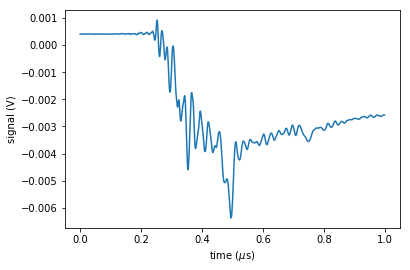

In [5]:
# plot
fig, ax = plt.subplots()

# data
dt = 1e6 * arr_info['dt']
xvals = np.arange(0, len(arr[0])*dt, dt)
yvals = np.mean(arr, axis=0)
ax.plot(xvals, yvals)

# format
ax.set_xlabel('time ($\mu$s)')
ax.set_ylabel('signal (V)')

# output
plt.show()

And DataFrame data can be accessed using the class method `H5Scan.df(dataset)`.

In [6]:
# DataFrame dataset
df = scan.df('analysis')
df.head()

,var,w0,w1,a0,a1,a2,f
measurement,,,,,,,
0,32.0500,777.950119,786.992730,0.000499,-0.005882,-1.118270,-0.006381
1,32.0505,777.950119,786.992729,0.000458,-0.006048,-1.122989,-0.006506
2,32.0510,777.950120,786.992729,0.000443,-0.005974,-1.138911,-0.006417
3,32.0515,777.950119,786.992729,0.000860,-0.005568,-0.995466,-0.006428
4,32.0520,777.950119,786.992729,0.000522,-0.005977,-1.095825,-0.006499


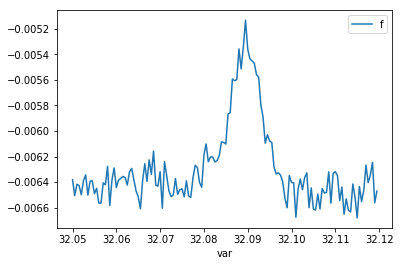

In [7]:
# plot the DataFrame for all squids
df.sort_values('var').plot('var', 'f')

# output
plt.show()

# `e11.H5Data()`
---

To access raw datasets using `e11.H5Data()` both the name of the dataset and the group in which it is located (i.e., the `squid`) must be specified.

In [8]:
fil = os.path.join(os.getcwd(), 'example_data', 'array_data.h5')
data = H5Data(fil)
# list the datasets that belong to the group `squid=1`.
squid = 1
data.datasets(squid)

['AV_0', 'IMG', 'OSC_0']

Array datasets can be read using the class method `H5Data.array(squid, dataset)`.

In this example, `OSC_0` contains 1d oscilloscope traces stored as rows in a 2d array of repeat measurements.

In [9]:
# Load 2D array data from the hdf5 file,
osc = data.array(squid, 'OSC_0', ignore_missing=False)
np.shape(osc)

100%|██████████| 1/1 [00:00<00:00, 108.52it/s]


(25, 2502)

This dataset contains traces with 2501 data points; 25 repeats are stored along the first dimension of the array.


In [10]:
# information about the dataset.
osc_info = data.attrs(squid, 'OSC_0')
osc_info

{'Manufacturer': 'LECROY',
 'Model': 'HDO4054',
 'Serial Number': 'LCRY3513N19955',
 'dt': 8.000000106811456e-10,
 'Averages': 10,
 'squid': 1}

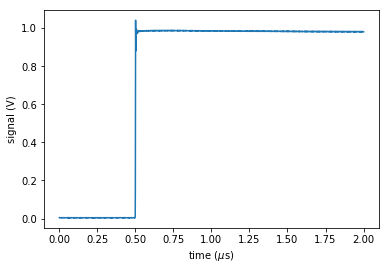

In [11]:
# plot
fig, ax = plt.subplots()

# average data
dt = 1e6 * osc_info['dt']
xvals = np.arange(0, len(osc[0])*dt, dt)
yvals = np.mean(osc, axis=0)
ax.plot(xvals, yvals)

# format
ax.set_xlabel('time ($\mu$s)')
ax.set_ylabel('signal (V)')

# output
plt.show()

Camera data are typically stored as 3d arrays of repeating 2d exposures.  These can also be accessed using `H5Data.array(squid, dataset)`.  

In the example below, the repeats are stored along axis=2.  This axis can be used to concatenate images from multiple squids into a single 3d array.

In [12]:
# image datasets
squids = [1, 2]
img = data.array(squids, 'IMG', axis=2, ignore_missing=True)
np.shape(img)

100%|██████████| 2/2 [00:00<00:00, 116.26it/s]


(128, 128, 19)

The combined data contains 19 images of 128 x 128 pixels.

In [13]:
# information about the dataset
img_info = data.attrs(squid, 'IMG')
img_info

{'Exposure (ms)': 1000,
 'Manufacturer': 'Sirius Cybernetics Corporation',
 'Model': 'image-o-matic',
 'squid': 1}

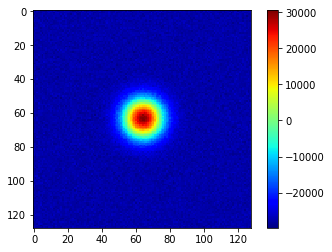

In [14]:
# average image
av_img = np.mean(img, axis=2)
cmap = 'jet'

# plot
fig, ax = plt.subplots()
image = ax.imshow(av_img, cmap=cmap)
cb = plt.colorbar(image)

# output
plt.show()

DataFrame data can be accessed using the class method `H5Data.df(squid, dataset)`.  As above, the arg `squid` can be a single value, or a list of values.  

In this example, the datasets `AV_0` from all of the file's groups are concatented into a single DataFrame.  This is done by passing `data.squids` as the first argument.

In [15]:
# load data from the hdf5 file,
av = data.df(data.squids, 'AV_0', label=None, ignore_missing=False)
av.head()

100%|██████████| 6/6 [00:00<00:00, 278.78it/s]


AB        CD        EF
squid measurement                              
1     0            0.983765  0.984008  0.004351
      1            0.984163  0.984424  0.004799
      2            0.983991  0.984383  0.004606
      3            0.983983  0.984222  0.004568
      4            0.983856  0.984048  0.004349

Here, `df.AB` is the mean oscilloscope signal in the time window `A` $\rightarrow$ `B`.  The window boundaries have been stored as dataset attributes.

In [16]:
av_info = data.attrs(squid, 'AV_0')
av_info

{'A': 2127, 'B': 893, 'C': 646, 'D': 709, 'E': 133, 'F': 437, 'squid': 1}

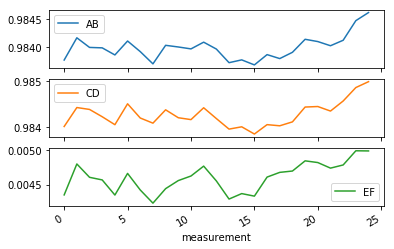

In [17]:
# plot the DataFrame for squid=1
av.loc[1, :].plot(subplots=True)

# output
plt.show()

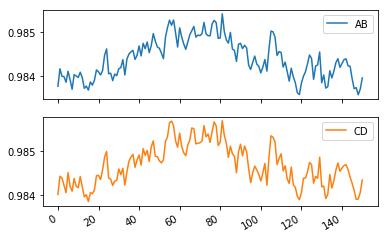

In [18]:
# plot the DataFrame for all squids
av.reset_index()[['AB', 'CD']].plot(subplots=True)

# output
plt.show()

Typically, you might want to load all of the data to process and analyse it all at once (as shown above).  

However, it's also very easy to load data from a subset of the groups in the hdf5 file, e.g., to ignore a known bad measurement.  For example,

In [19]:
# explicit list of squid values [3, 6]
explicit = data.df([3, 6], 'AV_0', label=None, ignore_missing=False)
explicit.head()

100%|██████████| 2/2 [00:00<00:00, 288.82it/s]


AB        CD        EF
squid measurement                              
3     0            0.984631  0.984778  0.004717
      1            0.984521  0.984731  0.004427
      2            0.984394  0.984799  0.004543
      3            0.984883  0.985223  0.004971
      4            0.985102  0.985331  0.005056

In [20]:
# range of squid values
func = lambda sq: 3 <= sq <= 5
sub = data.df(list(filter(func, data.squids)), 'AV_0', label=None, ignore_missing=False)
sub.head()

100%|██████████| 3/3 [00:00<00:00, 341.40it/s]


AB        CD        EF
squid measurement                              
3     0            0.984631  0.984778  0.004717
      1            0.984521  0.984731  0.004427
      2            0.984394  0.984799  0.004543
      3            0.984883  0.985223  0.004971
      4            0.985102  0.985331  0.005056

In [21]:
# even squid values
func = lambda sq: sq % 2 == 0
evens = data.df(list(filter(func, data.squids)), 'AV_0', label=None, ignore_missing=False)
evens.head()

100%|██████████| 3/3 [00:00<00:00, 234.00it/s]


AB        CD        EF
squid measurement                              
2     0            0.984051  0.984382  0.004700
      1            0.984060  0.984360  0.004719
      2            0.983892  0.984213  0.004472
      3            0.984043  0.984315  0.004631
      4            0.984005  0.984331  0.004587